In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.datasets.mnist as mnist 

In [2]:
# 数据导入，获取训练集和测试集
(train_image, train_labels), (test_image, test_labels) = tf.keras.datasets.mnist.load_data()
# train_image.shape,train_labels.shape为(60000, 28, 28), (60000,)

train_image = (train_image - 127.5)/127.5 # 把0-255的数据范围变为-1到1之间
test_image = (test_image - 127.5)/127.5 # 把0-255的数据范围变为-1到1之间

# 增加通道维度
train_image = tf.expand_dims(train_image, -1)
test_image = tf.expand_dims(test_image, -1)
# TensorShape([60000, 28, 28, 1]), (60000,)

# 类型转换
train_image = tf.cast(train_image, tf.float32)
test_image = tf.cast(test_image, tf.float32)
train_labels = tf.cast(train_labels, tf.int64)
test_labels = tf.cast(test_labels, tf.int64)

# 创建Dataset
dataset = tf.data.Dataset.from_tensor_slices((train_image, train_labels)).shuffle(60000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)

# 模型搭建
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax') # 对应0-9这10个数字
])
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()# 顺序编码用SparseCategoricalCrossentropy，（如果model最后一层未使用激活，则需要添加参数from_logits=True）
model.compile(optimizer=optimizer,loss=loss_func,metrics=['acc'])   # 编译模型
# 训练10个批次
history = model.fit(dataset,validation_data=test_dataset,epochs=10) # 返回字典类型的数据 其中记录了准确率和损失的信息

Epoch 1/10
235/235 [==============================] - 1s 4ms/step - loss: 0.4629 - acc: 0.8626 - val_loss: 0.2360 - val_acc: 0.9300
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 0.2085 - acc: 0.9391 - val_loss: 0.1739 - val_acc: 0.9496
Epoch 3/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1538 - acc: 0.9538 - val_loss: 0.1291 - val_acc: 0.9610
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1220 - acc: 0.9629 - val_loss: 0.1250 - val_acc: 0.9624
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1049 - acc: 0.9681 - val_loss: 0.1122 - val_acc: 0.9673
Epoch 6/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0925 - acc: 0.9722 - val_loss: 0.1031 - val_acc: 0.9671
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0812 - acc: 0.9752 - val_loss: 0.0919 - val_acc: 0.9712
Epoch 8/10
235/235 [==============================] - 1s 4ms/step - loss: 0.

In [3]:
predict_label = model.predict(test_image)

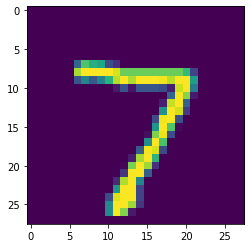

In [4]:
plt.imshow(test_image[0])

In [5]:
np.argmax(predict_label[0])

7

In [6]:
test_labels[0].numpy()

7

# 创建对抗样本图片
实现fast gradient sign method

> The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

> 第一步是创建扰动，它将被用来扭曲原始图像，从而产生一个敌对的图像。如前所述，对于这个任务，对图像进行梯度处理。

In [7]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

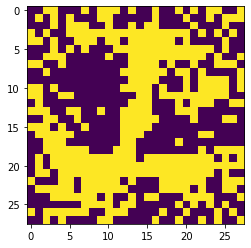

In [8]:
perturbations = create_adversarial_pattern(test_image, test_labels)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [9]:
def display_images(image, label,adv_label,num=10):
    fig = plt.figure(figsize=(2*num,3)) # figsize:指定figure的宽和高，单位为英寸
    for i in range(num):   # pre_image的shape的第一个维度就是个数，这里是num
        plt.subplot(1,num,i+1) # 几行几列的 第i+1个图片（从1开始）
        plt.imshow((image[i,:,:,:] + 1)/2) # 加1除2: 将生成的-1～1的图片弄到0-1之间,
        plt.title('{} -> {}'.format(label[i],adv_label[i]))
        plt.axis('off') # 不要坐标
    plt.show()

epsilons = 0:


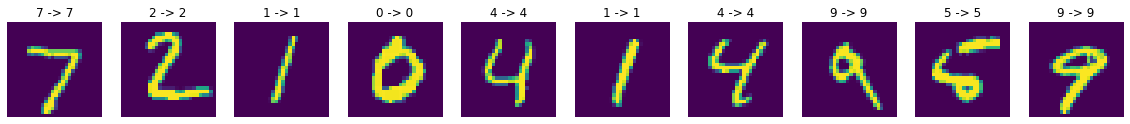

epsilons = 0.05:


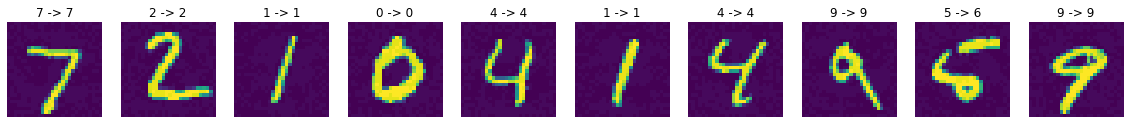

epsilons = 0.1:


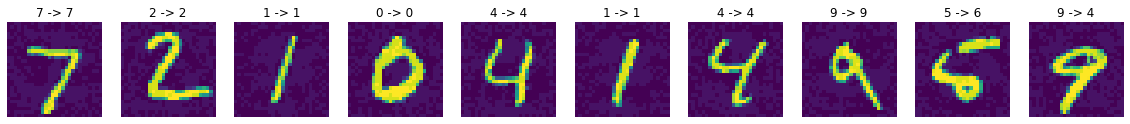

epsilons = 0.15:


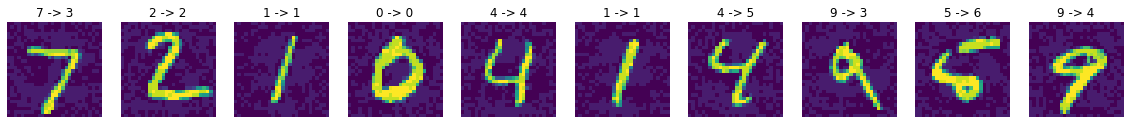

epsilons = 0.2:


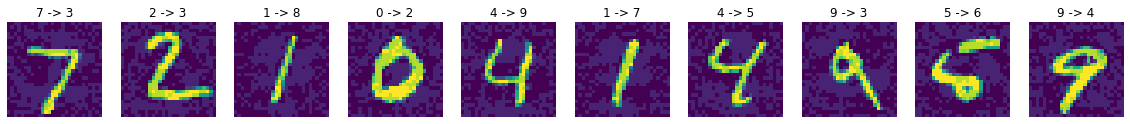

epsilons = 0.25:


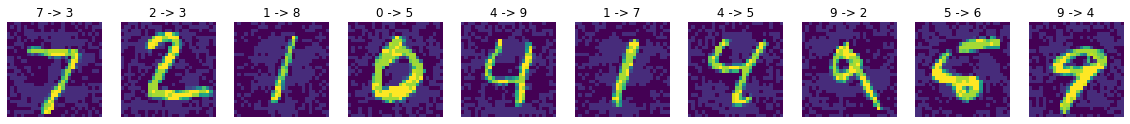

epsilons = 0.3:


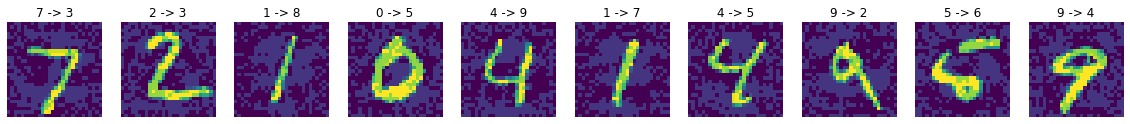

In [12]:
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  
  test_image = tf.clip_by_value(test_image, -1, 1)
  predict_label = model.predict(test_image)
  predict_label = np.array([np.argmax(i) for i in predict_label])
    
  adv_image = test_image + eps*perturbations
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  adv_predict_label = model.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])
  score = model.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])
  display_images(adv_image,predict_label,adv_predict_label)

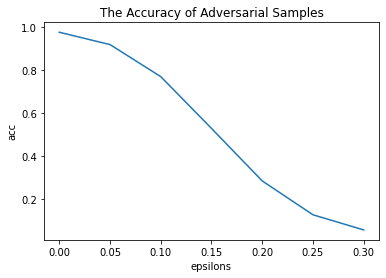

In [11]:
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.plot(epsilons,adv_acc_list)